# Основы машинного обучения (ИАД)
## НИУ ВШЭ, 2021-2022 учебный год

### Домашнее задание №8

In [1]:
import numpy as np
import pandas as pd
from sklearn.datasets import load_boston
from sklearn.model_selection import train_test_split
from sklearn.tree import DecisionTreeClassifier, DecisionTreeRegressor
from sklearn.metrics import accuracy_score, precision_score, recall_score, roc_auc_score, mean_squared_error

# Бустинг

## Градиентный бустинг своими руками (3 + 2* баллов)

Реализуйте алгоритм градиентного бустинга для регрессии. Напомним **основные формулы**.

Обозначим текущую композицию на $N-1$ шаге за $a_{N - 1}(x_i)$. Следующий базовый алгоритм $b_N(x_i)$ обучается на ответах $-\frac{\partial L(y_i, z)}{\partial z}\Bigl|_{z = a_{N - 1}(x_i)}$, где $L(y_i, z)$ — значение функции потерь на объекте при правильном ответе $y_i$ и предсказании $z$. Композиция на следующем шаге получается следующим образом:

$$
a_N(x_i) = a_{N-1}(x_i) + \nu\gamma_Nb_N(x_i)
$$

Здесь $\nu$ — гиперпараметр learning rate, $\gamma_N$ — оптимальный вес, настраиваемый на каждом шаге алгоритма, который можно найти по следующей формуле (обратите внимание на отсутствие $\nu$):

$$
\gamma_N = \mathrm{arg}\min_\gamma \frac{1}{\ell}\sum\limits_{i=1}^{\ell}L\left(y_i, a_{N - 1}(x_i) + \gamma b_N(x_i)\right)
$$

Можете принять $\gamma_N = 1$ для каждого $N$.

> Реализуйте нахождение оптимального $\gamma_N$ на каждом шаге, чтобы получить ещё 1 балл.


В качестве функции потерь возьмите **MSE**.

*Примечание. Вы можете использовать `DecisionTree` из `sklearn` и методы оптимизации из различных библиотек.*

In [74]:
# это может помочь вам для поиска оптимальных gamma
from scipy.optimize import minimize

In [187]:
class GradientBoosting:
    def __init__(self, n_estimators, max_depth, learning_rate=0.1):
        """
        PARAMETERS:
        n_estimators - number of trees in the ensemble
        max_depth - maximum depth of a tree
        learning_rate - coefficient by which new algorithm result is multiplied
        """
        self.n_estimators = n_estimators
        self.max_depth = max_depth
        self.learning_rate = learning_rate
        
    def fit(self, x, y):
        """
        INPUT:
        x - np.array of shape (l, d)
        y - np.array of shape (l,)
        """
        # Здесь нам нужно проитерироваться по n_estimators и обучить
        # соответствующее количество деревьев с помощью _fit_predict_tree(),
        # правильно обновляя y_new
        # Деревья нужно где-то сохранить, чтобы затем использовать в predict()
        
        self.gammas = [1]
        self.trees = []
        self.x = x
        self.y = y
        
        for i in range(self.n_estimators):
            if i == 0:
                zxc = DecisionTreeRegressor(max_depth=self.max_depth).fit(x,y)
                self.preds = np.array(zxc.predict(x))
                self.trees.append(zxc)
            else:
                y_new = y - self.preds 
                self.preds = self.preds + self._fit_predict_tree(x, y_new)

    def _fit_predict_tree(self, x, y):
        # Обучаем дерево и возвращаем его предикшн
        tree = DecisionTreeRegressor(max_depth=self.max_depth)
        tree.fit(x, y)
        self.trees.append(tree)
        gamma_min = minimize(x0 = [1], fun = self.func, method='Powell')
        self.gammas.append(gamma_min.x)
        return self.gammas[-1] * self.learning_rate * tree.predict(x)
    
    def func(self, gamma):
        y_pred_with_out_one = self.trees[0].predict(self.x)
        
        for i in range(1, len(self.trees) - 1):
            y_pred_with_out_one += self.trees[i].predict(self.x) * gamma * self.learning_rate
            
        return mean_squared_error(self.y,y_pred_with_out_one + gamma*self.trees[-1].predict(self.x))
        
    def predict(self, x):
        """
        INPUT:
        x - np.array of shape (m, d)
        OUTPUT:
        y_pred - np.array of shape (m,)
        """
        # Используем сохранённые деревья для расчёта агрегированного предикшна
        
        y_pred = self.trees[0].predict(x)
        
        for i in range(1, self.n_estimators):
            y_pred += self.trees[i].predict(x) * self.gammas[i] * self.learning_rate
            
        
        
        return y_pred

Проверьте вашу реализацию на Boston dataset. 

> Подберите оптимальные гиперпараметры, чтобы победить RandomForestRegressor как в обычном случае, так и при нахождении оптимального шага **(не меняйте параметры сида)**. При необходимости воспользуйтесь GridSearch. За это вы получите ещё 1 балл.



In [168]:
boston = load_boston()
X = boston.data
y = boston.target
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.25, random_state=13)

In [169]:
from sklearn.ensemble import RandomForestRegressor

rf = RandomForestRegressor(max_features=4, n_estimators=640, random_state=19052019)

rf.fit(X_train, y_train)
mean_squared_error(y_test, rf.predict(X_test))

9.63198271791959

In [218]:
np.random.seed(19052019)

gb = GradientBoosting(n_estimators=100, max_depth = 2, learning_rate= 0.2)


gb.fit(X_train, y_train)
y_pred = gb.predict(X_test)

In [219]:
mean_squared_error(y_test, y_pred)

16.863005021311956

Для удобства проверяющего укажите, пожалуйста, реализовали ли вы нахождение оптимального шага?

- Да!

## Прогнозируем задержки самолётов (2 балла)

Поработаем с задачей про задержки самолётов. На основании доступных данных о рейсе вам нужно определить, будет ли он задержан на 15 минут.
Воспользуйтесь любыми методами градиентного бустинга {`XGboost`, `catboost`, `LightGBM`} и `GridSearchCV` для достижения результата.

> Получите 1 балл за преодоление порога roc_auc_score 0.72 и ещё 1 балл за преодоление порога 0.74.



In [6]:
import lightgbm as lgb

from sklearn.model_selection import GridSearchCV

from sklearn.model_selection import train_test_split
from sklearn.metrics import roc_auc_score

In [7]:
train = pd.read_csv('https://raw.githubusercontent.com/PersDep/data-mining-intro-2021/main/hw08-boosting-clustering-data/flight_delays_train.csv')
test = pd.read_csv('https://raw.githubusercontent.com/PersDep/data-mining-intro-2021/main/hw08-boosting-clustering-data/flight_delays_test.csv')

In [15]:
train.head()

Month DayofMonth DayOfWeek  DepTime UniqueCarrier Origin Dest  Distance  \
0   c-8       c-21       c-7     1934            AA    ATL  DFW       732   
1   c-4       c-20       c-3     1548            US    PIT  MCO       834   
2   c-9        c-2       c-5     1422            XE    RDU  CLE       416   
3  c-11       c-25       c-6     1015            OO    DEN  MEM       872   
4  c-10        c-7       c-6     1828            WN    MDW  OMA       423   

  dep_delayed_15min  
0                 N  
1                 N  
2                 N  
3                 N  
4                 Y

In [49]:
# Референс
from xgboost.sklearn import XGBClassifier

X_train = train[['Distance', 'DepTime']].values
y_train = train['dep_delayed_15min'].map({'Y': 1, 'N': 0}).values
X_test = test[['Distance', 'DepTime']].values
X_train_part, X_valid, y_train_part, y_valid = train_test_split(X_train, y_train, test_size=0.3)

xgb_model = XGBClassifier()
xgb_model.fit(X_train_part, y_train_part)
roc_auc_score(y_valid, xgb_model.predict_proba(X_valid)[:, 1])

0.705665453010069

In [231]:
from catboost import CatBoostClassifier
from sklearn.preprocessing import LabelEncoder

train = pd.read_csv('https://raw.githubusercontent.com/PersDep/data-mining-intro-2021/main/hw08-boosting-clustering-data/flight_delays_train.csv')

le = LabelEncoder()
train[train.columns] = train[train.columns].apply(le.fit_transform)

X_train = train.drop(columns=["dep_delayed_15min"])
y_train = train['dep_delayed_15min']

X_train_part, X_valid, y_train_part, y_valid = train_test_split(X_train, y_train, test_size=0.3, random_state=42)

model = CatBoostClassifier()

model.fit(
    X_train_part, y_train_part,
    verbose=False
)

roc_auc_score(y_valid, model.predict_proba(X_valid)[:, 1])

0.7431273691743258

In [ ]:
# Демонстрация того насколько крут катбуст даже без указания параметров! Ну и конечно LabelEncoding тут тоже 
# не остается без внимания.

# Кластеризация

## DBSCAN своими руками (3 + 2* баллов)


```
DBSCAN: Density-based spatial clustering of applications with noise
```


Реализуйте класс dbscan.

Алгоритм имеет два основных гиперпараметра:
1. `eps` &mdash; радиус рассматриваемой окрестности
2. `min_samples` &mdash; число соседей в окрестности

Для выполнения кластеризации DBSCAN точки делятся на основные точки, достижимые по плотности точки и выпадающие следующим образом:

- Точка $p$ является основной точкой, если по меньшей мере `min_samples` точек находятся на расстоянии, не превосходящем 
`eps` от неё. Говорят, что эти точки достижимы прямо из $p$.

-  Точка $q$ прямо достижима из $p$, если точка $q$ находится на расстоянии, не большем `eps`, от точки $p$, и $p$ — основная точка.
Точка $q$ достижима из $p$, если имеется путь 
$p_1,…,p_n$ где $p_1=p$ и $p_n=q$ , а каждая точка $p_{i+1}$ достижима прямо из $p_i$ (все точки на пути должны быть основными, за исключением $q$).

Все точки, не достижимые из основных точек, считаются выбросами.

Теперь, если $p$ является основной точкой, то она формирует кластер вместе со всеми точками (основными или неосновными), достижимыми из этой точки. Каждый кластер содержит по меньшей мере одну основную точку. Неосновные точки могут быть частью кластера, но они формируют его «край», поскольку не могут быть использованы для достижения других точек.


In [50]:
# Это может помочь вам для поиска дистанции между точками
from scipy.spatial import distance

In [499]:
# Рекомендации -- это только рекомендации
class dbscan:
    def __init__(self, eps, min_samples):
        self.eps = eps
        self.min_samples = min_samples

        
    def fit_predict(self, X):
        # Помечаем переданные точки, чтобы отличать уже кластеризованные
        # или являющиеся шумом от остальных
        self.X = X
        self.cluster_number = 0
        self.point = np.array([-1]*X.shape[0])
        
        self.distances = [self.range_query1(x) for x in X]
       
        for i in range(self.X.shape[0]):
            if self.point[i] == -1:
                neighbours = self.range_query(i)
                if len(neighbours) < self.min_samples:
                    self.point[i] = 0
                else:
                    self.cluster_number += 1
                    self.grow_cluster(i, neighbours)

        return self.point
        


    def grow_cluster(self, root, neighbours):
        # В этой функции мы полностью строим кластер относительно переданной точки
        # Т.е. реализуем цикл по структуре данных, изначально состоящей из уже
        # известных соседей (neighbours) и в процессе пополняющейся
        # "соседями соседей" с помощью range_query()
        # your code here
        
        self.point[root] = self.cluster_number
        
        
        for q in neighbours:
            new_neighbours = self.range_query(q)
            if (len(new_neighbours) >= self.min_samples) and (self.point[q] == -1): 
                self.grow_cluster(q, new_neighbours)
            else:
                self.point[q] = self.cluster_number
        
    def range_query1(self, x):
        """Возвращает точки на расстоянии <= eps от x"""
        # С помощью функции dist()
        # your code here
        claster_chunk = []
        for i in range(self.X.shape[0]):
            if self.dist(self.X[i], x) <= self.eps:
                claster_chunk.append(i)
        return claster_chunk
    
    def range_query(self, x):
        """Возвращает точки на расстоянии <= eps от x"""
        # С помощью функции dist()
        # your code here
        
        return self.distances[x]
            

    
    @staticmethod
    def dist(a, b):
        """Метрика расстояния"""
        # Попробуйте что-нибудь из scipy.spatial.distance
        # Базовый вариант -- Евклидова метрика
        return distance.euclidean(a,b)
        

Проверим себя на простом примере:

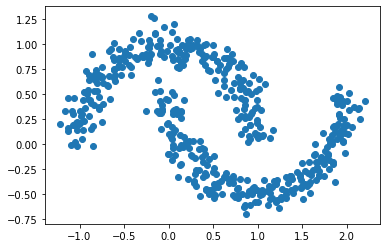

In [503]:
from sklearn.datasets import make_moons
import matplotlib.pyplot as plt
import pandas as pd

X, _ = make_moons(n_samples=500, noise=0.1)
plt.scatter(X[:,0], X[:,1])
plt.show()

Кластеризуйте это с помощью своей версии DBSCAN:

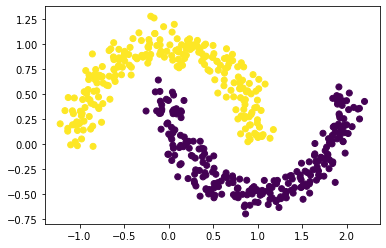

In [504]:
clusters = dbscan(eps=0.2, min_samples=10).fit_predict(X)

plt.scatter(X[:,0], X[:,1], c=clusters)
plt.show()

Референс:

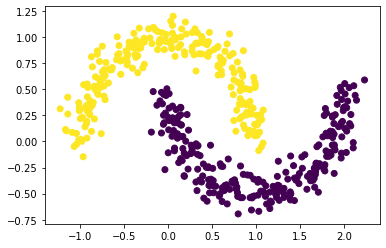

In [382]:
from sklearn.cluster import DBSCAN

clusters = DBSCAN(eps=0.2, min_samples=10).fit_predict(X)

plt.scatter(X[:,0], X[:,1], c=clusters)
plt.show()


> Получите 1 балл за ещё один интересный пример кластеризации (в качестве референса используйте предоставленное изображение. Нужно несколько интересных соседствующих форм):



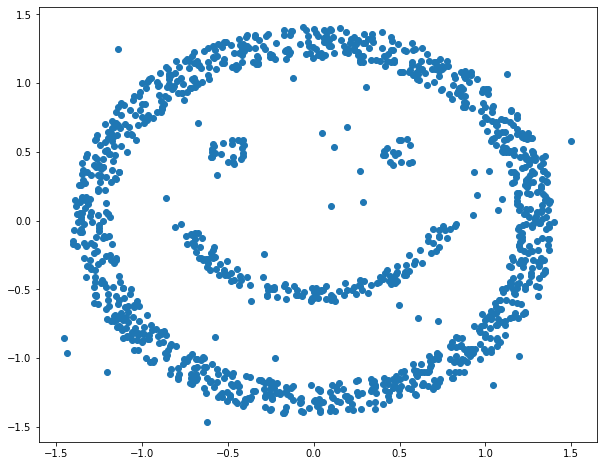

In [508]:
smile = []

# Нарисуем смайлик
for _ in range(5000):
    x = np.random.sample()*3 - 1.5
    y = np.random.sample()*3 - 1.5
    if ((x ** 2 + y ** 2) > 1.4) and ((x ** 2 + y ** 2) <= 2):
        smile.append([x,y])
    if (x>0.4 and x<0.6) and (y>0.4 and y<0.6):
        smile.append([x,y])
    if (x<-0.4 and x>-0.6) and (y>0.4 and y<0.6):
        smile.append([x,y])
    if (((x ** 2 + (y-0.3) ** 2) > 0.6) and ((x ** 2 + (y-0.3) ** 2) <= 0.8)) and (y < 0) :
        smile.append([x,y])
        
# Добавим шума
for _ in range(50):  
    x = np.random.sample()*3 - 1.5
    y = np.random.sample()*3 - 1.5
    smile.append([x, y])
    
smile = np.array(smile)
plt.figure(figsize=(10,8))
plt.scatter(smile[:,0], smile[:,1])
plt.show()

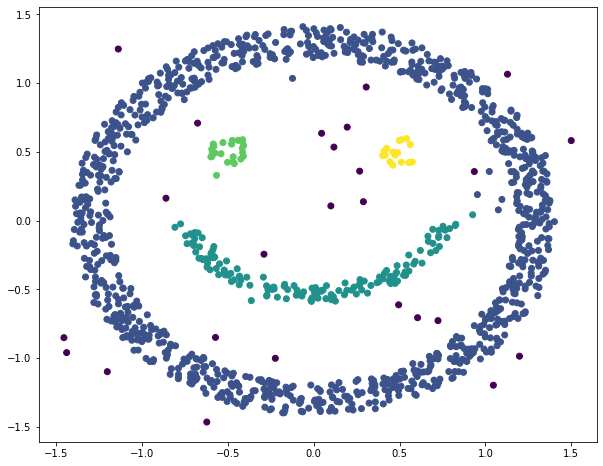

In [509]:
clusters = dbscan(eps=0.15, min_samples=10).fit_predict(smile)

plt.figure(figsize=(10,8))
plt.scatter(smile[:,0], smile[:,1], c=clusters)
plt.show()

# Получилось довольно мило


> Получите ещё 1 балл, если время работы вашего алгоритма больше референсного не более чем в 100 раз с учётом погрешности 3% от вашего времени:



In [409]:
%%time
%%capture
clusters = DBSCAN(eps=0.2, min_samples=10).fit_predict(X)

CPU times: user 6.71 ms, sys: 16.3 ms, total: 23 ms
Wall time: 24.7 ms


In [410]:
%%time
%%capture
clusters = dbscan(eps=0.2, min_samples=10).fit_predict(X)

CPU times: user 2.01 s, sys: 7.13 ms, total: 2.02 s
Wall time: 2.02 s


In [ ]:
# В моем случае алгоритм работает в 80 раз медленне, что удовлетворяет условию получения балла
# Можно было сделать лучше, но так как времени мало на дз, оставлю как есть.

## Применяем DBSCAN (3 балла)

__[1.5 балла]__ Возьмите колонки `Distance` и `DepTime` (из датасета о задержках самолётов). Запустите на тренировочной выборке на них DBSCAN. Нарисуйте облоко рассеивания с получившимися кластерами. Насколько много их вышло? 

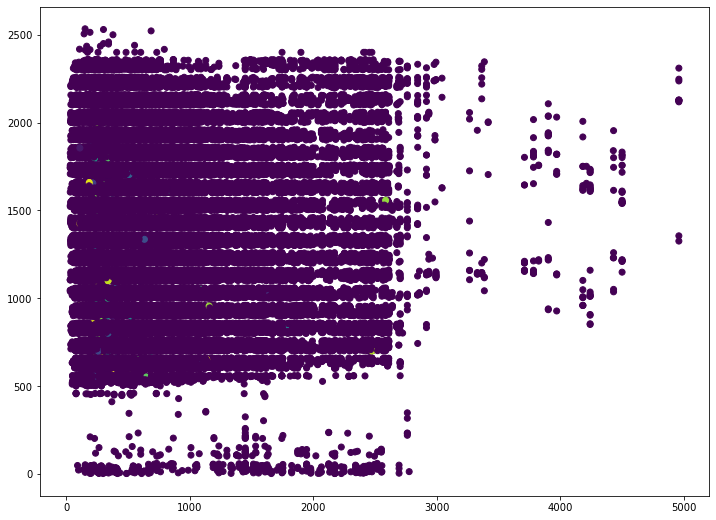

In [529]:
train = pd.read_csv('https://raw.githubusercontent.com/PersDep/data-mining-intro-2021/main/hw08-boosting-clustering-data/flight_delays_train.csv')
X = train[['Distance', 'DepTime']].values

clusters = DBSCAN().fit_predict(X)

plt.figure(figsize=(12,9))
plt.scatter(X[:,0], X[:,1], c = clusters)
plt.show()

# Формально говоря получилось 0 кластеров, за исключением пары незначитльных вкроплений, а все остальные точки -
# шумовые, так как тут расстояния между точек слишком большие и для нашего eps = 5 по умолчанию нет 5 объектов 
# соседей

Попробуйте перебрать параметры `eps` и `min_samples` по решётке и нарисовать для каждой пары облако рассеивания. При каких параметрах шумовых точек оказывается больше всего? Почему так происходит? 

__Ответ:__ 

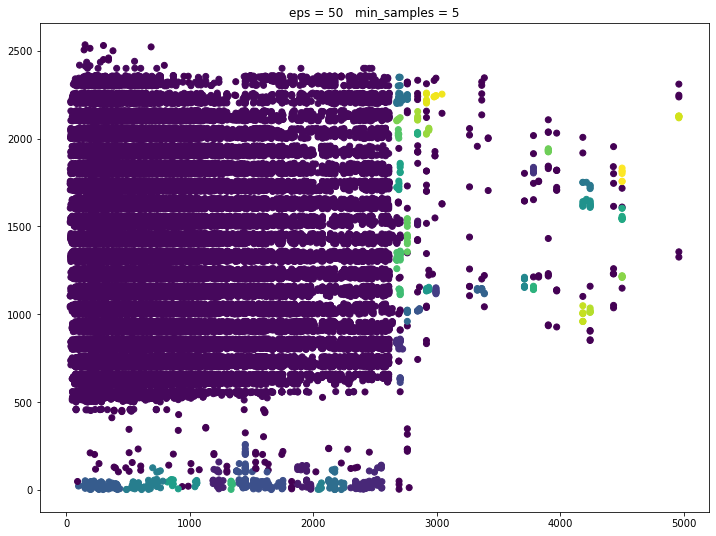

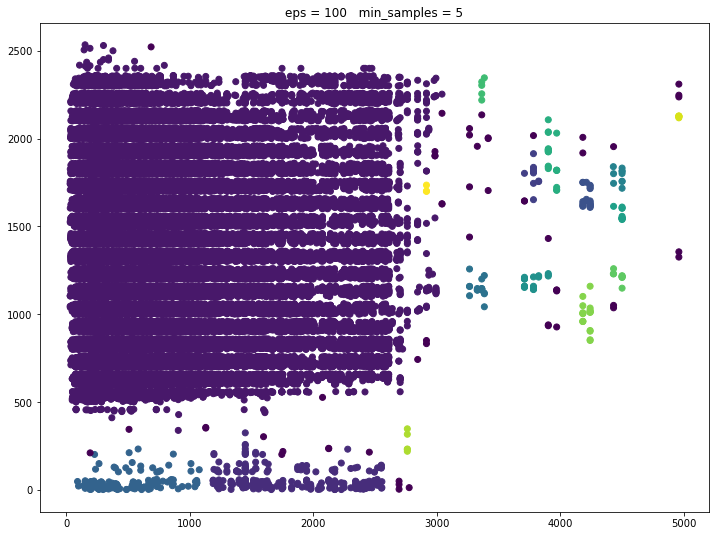

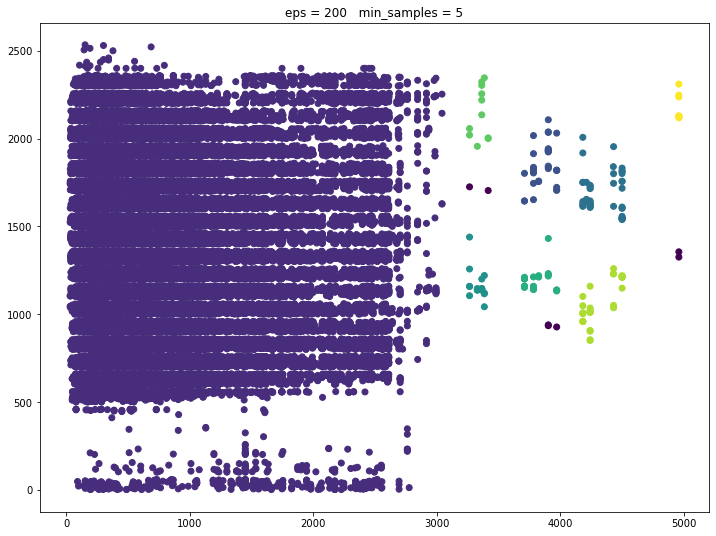

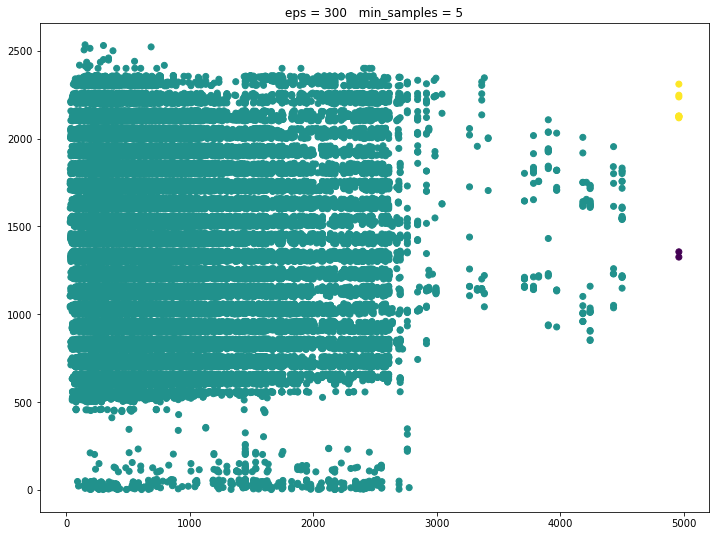

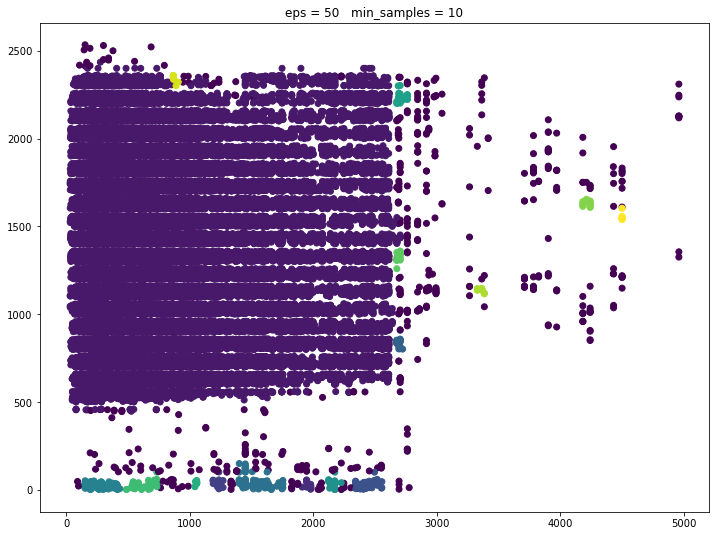

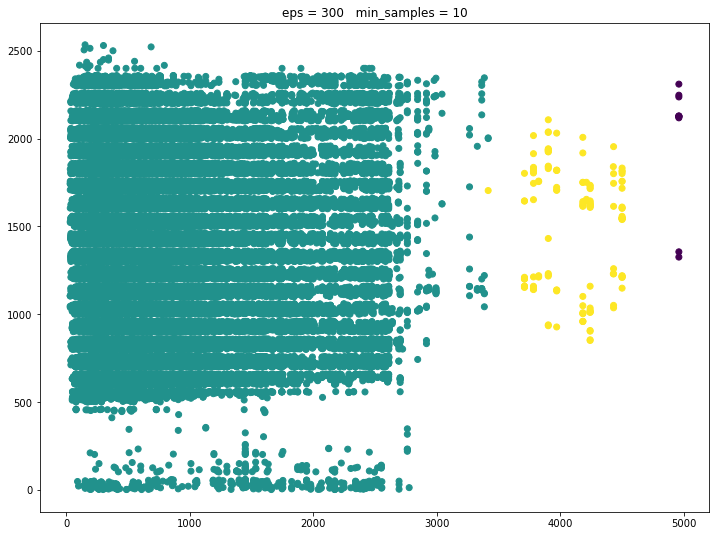

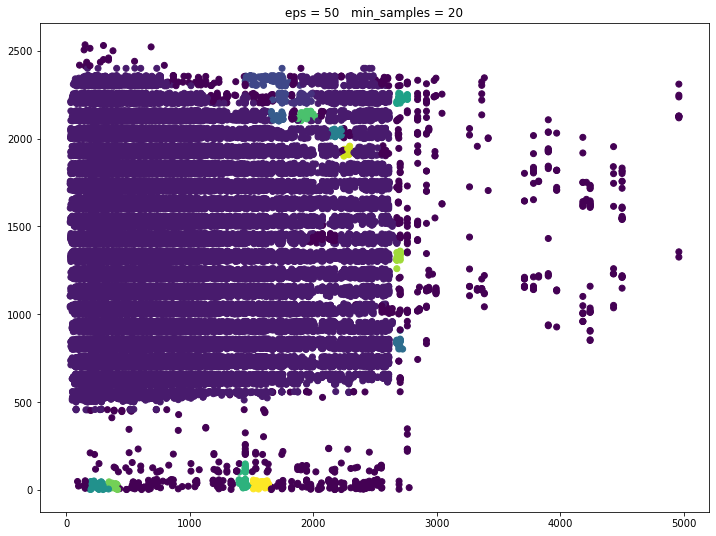

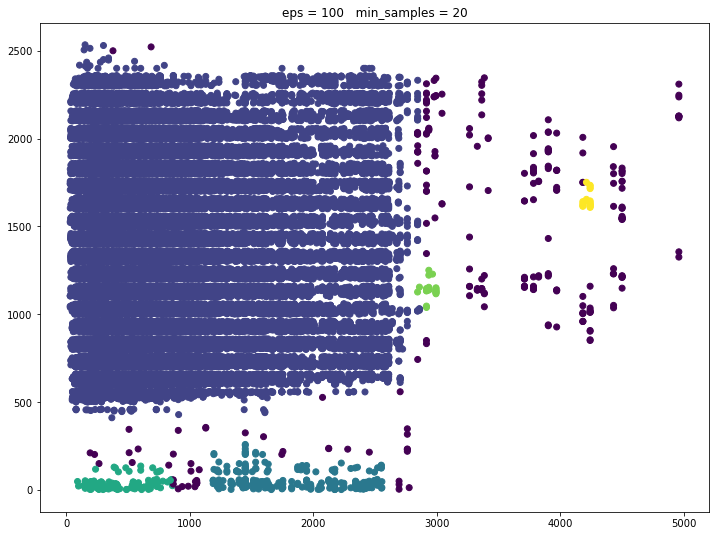

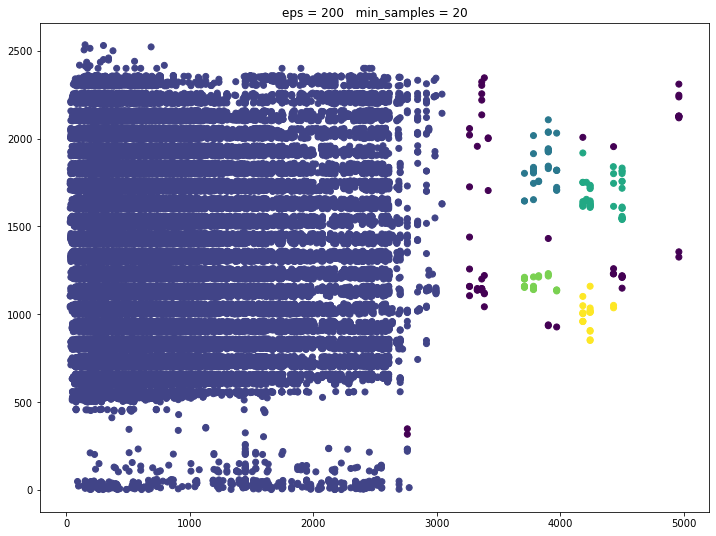

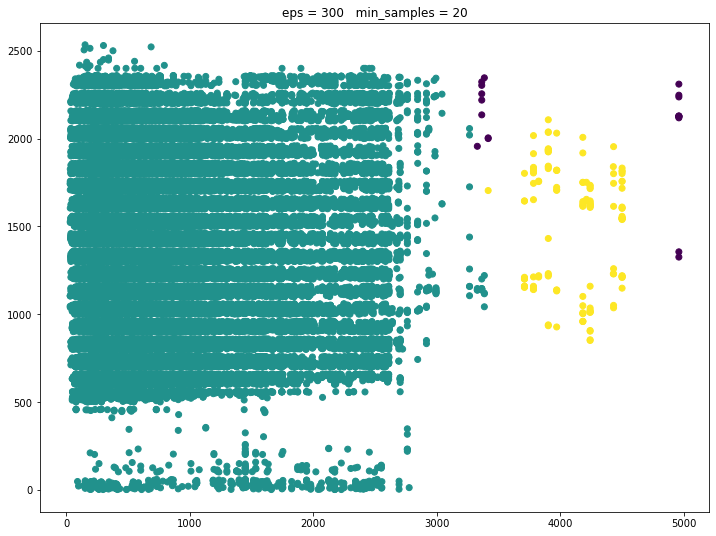

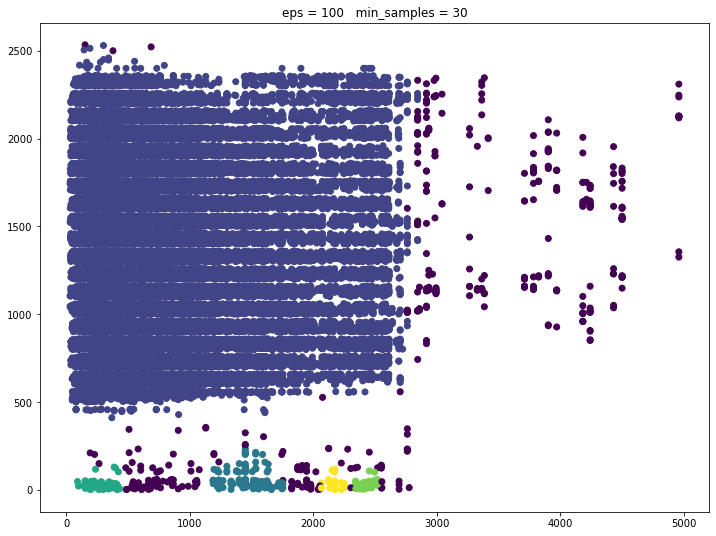

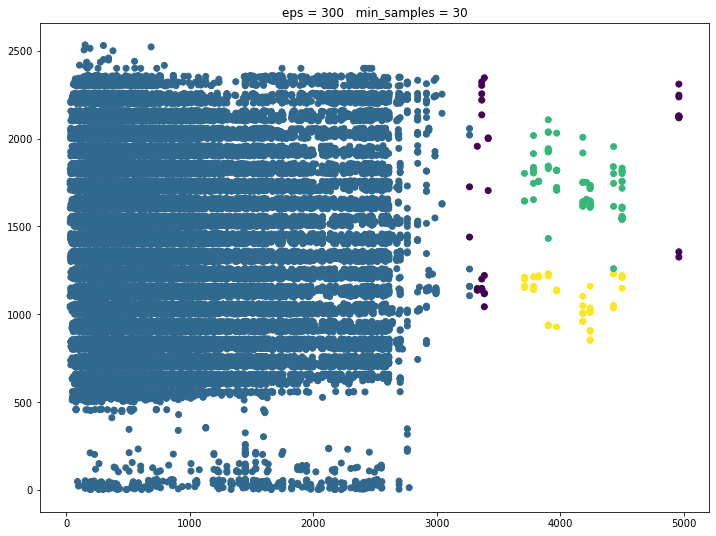

In [532]:
for eps, min_samples in [[50, 5], [100, 5], [200, 5], [300, 5],
                         [50, 10], [100, 10], [200, 10], [300, 10],
                         [50, 20], [100, 20], [200, 20], [300, 20],
                         [50, 30], [100, 30], [200, 30], [300, 30]]:
    
    clusters = DBSCAN(eps=eps, min_samples=min_samples).fit_predict(X)
    plt.figure(figsize=(12,9))
    plt.title(f"eps = {eps}   min_samples = {min_samples}")
    plt.scatter(X[:,0], X[:,1], c = clusters)
    plt.show()

# Наибольшее количество шумовых точек получется при либо маленьком eps, либо слишком большом min_sample.
# Это происходит, потому что точки не могут стать основными, ведь при маленько eps маловероятно что остальные точки
# будут настолько близко, также как и маловероятно огромное количество точек будет в окрестности eps при большом 
# min_sample. В нашем случае наиболее оптимальное разбиение получилось при eps = 100, min_samples = 20

__[1.5 балла]__ Добавьте в датасет новую категориальную переменную: номер кластера из DBSCAN и обучите Catboost со своими лучшими гиперпараметрами. Улучшилось ли качество модели на тестовой выборке? Как думаете, почему? 

In [553]:
from catboost import CatBoostClassifier

train = pd.read_csv('https://raw.githubusercontent.com/PersDep/data-mining-intro-2021/main/hw08-boosting-clustering-data/flight_delays_train.csv')


X_train = train[['Distance', 'DepTime']].values
y_train = train['dep_delayed_15min'].map({'Y': 1, 'N': 0}).values

X_train_part, X_valid, y_train_part, y_valid = train_test_split(X_train, y_train, test_size=0.3)

model = CatBoostClassifier()

model.fit(X_train_part, y_train_part, verbose = False)

roc_auc_score(y_valid, model.predict_proba(X_valid)[:, 1])

0.7027144667462337

In [17]:
from catboost import CatBoostClassifier

train = pd.read_csv('https://raw.githubusercontent.com/PersDep/data-mining-intro-2021/main/hw08-boosting-clustering-data/flight_delays_train.csv')

X = train[['Distance', 'DepTime']].values
clusters = DBSCAN(eps=100, min_samples=20).fit_predict(X)
train["Clusters"] = clusters

X_train = train[['Distance', 'DepTime', 'Clusters']].values
y_train = train['dep_delayed_15min'].map({'Y': 1, 'N': 0}).values
X_train_part, X_valid, y_train_part, y_valid = train_test_split(X_train, y_train, test_size=0.3)

model = CatBoostClassifier()
model.fit(X_train_part, y_train_part, verbose = False)

roc_auc_score(y_valid, model.predict_proba(X_valid)[:, 1])

0.7102923218540178

__Ответ:__ Так как до этого использовал катбуст в первоначальном виде, то и сейчас будем обучать его безо всяких гиперпараметров (Также, мы все знаем, что катбуст славится тем, что даже без спецификации гиперпараметров может показать хорошее качество). В первый раз мы обучили катбуст на тех же двух признаках, а во второй уже на трех, добавив признак clusters. Качество возрасло на 0.01, что является неплохим результатом. Это произошло, потому что мы добавили действительно информативный признак, дающий новые вводные о выборке, что в нашем случае помогло нашим базовым моделям (деревьям) более оптимально разделить нашу выборку и, соотвественно, приблизить целевую переменную.
Крутой метод - лайк, однако не всегда будет полезен.

# Небольшие подарочки

**+0.1 балла** за фотографию того, как вы проводите лето на открытом воздухе

**+0.1 балла** за смешной мем по машинному обучению

**+0.1 балла** за развернутый отзыв о курсе: ваших впечатлениях, сложностях и радостях, любимых темах и т.д.